# Detección de Fraude con Aprendizaje Semi-Supervisado

## Pseudocódigo Formal del Algoritmo Self-Training

**ALGORITMO** `SelfTraining(D_labeled, D_unlabeled, threshold)`

**ENTRADA:**
- `D_labeled ← {(x₁, y₁), (x₂, y₂), …, (xₙ, yₙ)}` (conjunto de datos etiquetados)
- `D_unlabeled ← {x₁', x₂', …, xₘ'}` (conjunto de datos sin etiquetas)
- `threshold` (umbral de confianza para pseudo-etiquetado)

**SALIDA:**
- Modelo entrenado `M_final`
- Conjunto expandido `D_expanded` con pseudo-etiquetas

**PASOS:**

1. **Inicialización:**
   - `M ← entrenar_modelo_base(D_labeled)`
   - `D_temp ← D_labeled`
   - `D_remaining ← D_unlabeled`

2. **MIENTRAS** `D_remaining ≠ ∅` **Y** condición de parada no cumplida:
   
   a. **Predecir con confianza:**
      - Para cada `xᵢ ∈ D_remaining`:
        - `prob_i ← M.predict_proba(xᵢ)`
        - `confidence_i ← MAX(prob_i)`
   
   b. **Seleccionar predicciones de alta confianza:**
      - `D_confident ← {(xᵢ, ŷᵢ) | confidence_i ≥ threshold}`
      - Donde `ŷᵢ ← argmax(prob_i)`
   
   c. **SI** `D_confident = ∅` **ENTONCES**:
      - **ROMPER** (no hay predicciones confiables)
   
   d. **Expandir conjunto etiquetado:**
      - `D_temp ← D_temp ∪ D_confident`
      - `D_remaining ← D_remaining \ D_confident`
   
   e. **Re-entrenar modelo:**
      - `M ← entrenar_modelo(D_temp)`

3. **RETORNAR** modelo final `M` y conjunto expandido `D_temp`



### 1. Importacion de Librerias y Carga de Datos

In [5]:
# Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

# Cargar datos
datos_entrenamiento = pd.read_csv("application_train.csv")
print(f"Datos: {datos_entrenamiento.shape} | Fraude: {datos_entrenamiento['TARGET'].mean()*100:.1f}%")
datos_entrenamiento.head()

Datos: (307511, 122) | Fraude: 8.1%


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### 2. Preprocesamiento de Datos

In [ ]:
# Seleccionar variables numericas
datos_numericos = datos_entrenamiento.select_dtypes(include=[np.number])
print(f"Variables numericas: {datos_numericos.shape[1]}")

Variables numericas: 106


In [ ]:
# Seleccionar variables categoricas
datos_categoricos = datos_entrenamiento.select_dtypes(include=['object'])
print(f"Categoricas: {datos_categoricos.shape[1]}")

Categoricas: 16


In [6]:
# Renombrar columnas a español
nombres_espanol = {
    'TARGET': 'objetivo',
    'CNT_CHILDREN': 'num_hijos',
    'CNT_FAM_MEMBERS': 'num_miembros_familia',
    'AMT_INCOME_TOTAL': 'ingreso_total',
    'AMT_CREDIT': 'monto_credito',
    'AMT_ANNUITY': 'anualidad',
    'AMT_GOODS_PRICE': 'precio_bienes',
    'DAYS_BIRTH': 'edad_dias',
    'DAYS_EMPLOYED': 'dias_empleado',
    'DAYS_REGISTRATION': 'dias_registro',
    'DAYS_ID_PUBLISH': 'dias_publicacion_id',
    'OWN_CAR_AGE': 'edad_auto',
    'EXT_SOURCE_1': 'score_externo_1',
    'EXT_SOURCE_2': 'score_externo_2',
    'EXT_SOURCE_3': 'score_externo_3',
    'REGION_POPULATION_RELATIVE': 'poblacion_region',
    'REGION_RATING_CLIENT': 'calificacion_region',
    'REGION_RATING_CLIENT_W_CITY': 'calificacion_region_ciudad',
    'FLAG_MOBIL': 'tiene_movil',
    'FLAG_EMP_PHONE': 'tiene_telefono_trabajo',
    'FLAG_WORK_PHONE': 'tiene_telefono_laboral',
    'FLAG_CONT_MOBILE': 'movil_contactable',
    'FLAG_PHONE': 'tiene_telefono',
    'FLAG_EMAIL': 'tiene_email',
    'HOUR_APPR_PROCESS_START': 'hora_solicitud',
    'OBS_30_CNT_SOCIAL_CIRCLE': 'obs_30dias_circulo_social',
    'DEF_30_CNT_SOCIAL_CIRCLE': 'def_30dias_circulo_social',
    'OBS_60_CNT_SOCIAL_CIRCLE': 'obs_60dias_circulo_social',
    'DEF_60_CNT_SOCIAL_CIRCLE': 'def_60dias_circulo_social',
    'DAYS_LAST_PHONE_CHANGE': 'dias_ultimo_cambio_telefono',
    'AMT_REQ_CREDIT_BUREAU_HOUR': 'consultas_buro_ultima_hora',
    'AMT_REQ_CREDIT_BUREAU_DAY': 'consultas_buro_ultimo_dia',
    'AMT_REQ_CREDIT_BUREAU_WEEK': 'consultas_buro_ultima_semana',
    'AMT_REQ_CREDIT_BUREAU_MON': 'consultas_buro_ultimo_mes',
    'AMT_REQ_CREDIT_BUREAU_QRT': 'consultas_buro_ultimo_trimestre',
    'AMT_REQ_CREDIT_BUREAU_YEAR': 'consultas_buro_ultimo_ano',
    'NAME_CONTRACT_TYPE': 'tipo_contrato',
    'CODE_GENDER': 'genero',
    'FLAG_OWN_CAR': 'tiene_auto',
    'FLAG_OWN_REALTY': 'tiene_propiedad',
    'NAME_TYPE_SUITE': 'tipo_acompanante',
    'NAME_INCOME_TYPE': 'tipo_ingreso',
    'NAME_EDUCATION_TYPE': 'nivel_educacion',
    'NAME_FAMILY_STATUS': 'estado_civil',
    'NAME_HOUSING_TYPE': 'tipo_vivienda',
    'OCCUPATION_TYPE': 'ocupacion',
    'WEEKDAY_APPR_PROCESS_START': 'dia_semana_solicitud',
    'ORGANIZATION_TYPE': 'tipo_organizacion',
    'FONDKAPREMONT_MODE': 'modo_fondo_reparacion',
    'HOUSETYPE_MODE': 'modo_tipo_casa',
    'WALLSMATERIAL_MODE': 'modo_material_paredes',
    'EMERGENCYSTATE_MODE': 'modo_estado_emergencia'
}

datos_entrenamiento = datos_entrenamiento.rename(columns=nombres_espanol)
datos_numericos = datos_entrenamiento.select_dtypes(include=[np.number])
datos_categoricos = datos_entrenamiento.select_dtypes(include=['object'])

In [7]:
datos_numericos = datos_numericos.fillna(datos_numericos.median())

In [8]:
# Imputar nulos categoricos con moda
datos_categoricos = datos_categoricos.fillna(datos_categoricos.mode().iloc[0])
print("Nulos categoricos imputados")

Nulos categoricos imputados


In [9]:
# Codificar variables categoricas a numeros
from sklearn.preprocessing import LabelEncoder

columnas_categoricas = datos_entrenamiento.select_dtypes(include=['object']).columns
datos_categoricos_codificados = datos_categoricos.copy()

for columna in columnas_categoricas:
    le = LabelEncoder()
    datos_categoricos_codificados[columna] = le.fit_transform(datos_categoricos_codificados[columna].astype(str))

print(f"Codificadas: {len(columnas_categoricas)} variables")
datos_categoricos_codificados.head()

Codificadas: 16 variables


,tipo_contrato,genero,tiene_auto,tiene_propiedad,tipo_acompanante,tipo_ingreso,nivel_educacion,estado_civil,tipo_vivienda,ocupacion,dia_semana_solicitud,tipo_organizacion,modo_fondo_reparacion,modo_tipo_casa,modo_material_paredes,modo_estado_emergencia
0,0,1,0,1,6,7,4,3,1,8,6,5,2,0,5,0
1,0,0,0,0,1,4,1,1,1,3,1,39,2,0,0,0
2,1,1,1,1,6,7,4,3,1,8,1,11,2,0,4,0
3,0,0,0,1,6,7,4,0,1,8,6,5,2,0,4,0
4,0,1,0,1,6,7,4,3,1,3,4,37,2,0,4,0


In [10]:
# Combinar datos numericos y categoricos
datos_completos = pd.concat([datos_numericos, datos_categoricos_codificados], axis=1)
print(f"Dataset final: {datos_completos.shape}")

Dataset final: (307511, 122)


In [11]:
# Separar X e y
X = datos_completos.drop('objetivo', axis=1)
y = datos_completos['objetivo']
print(f"Datos: {X.shape[0]} muestras, {X.shape[1]} caracteristicas")
print(f"Fraude: {y.mean()*100:.1f}%")

Datos: 307511 muestras, 121 caracteristicas
Fraude: 8.1%


In [ ]:
# Dividir en etiquetados 15% y no etiquetados 85%
X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(
    X, y, train_size=0.15, stratify=y, random_state=42
)
y_unlabeled_masked = np.full(len(y_unlabeled), -1)

print(f"Etiquetados: {X_labeled.shape[0]} (15%) | No etiquetados: {X_unlabeled.shape[0]} (85%)")


Etiquetados: 30751 (10%) | No etiquetados: 276760 (90%)


In [13]:
# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_labeled, y_labeled, test_size=0.2, stratify=y_labeled, random_state=42
)

In [14]:
# Normalizar datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_unlabeled_scaled = scaler.transform(X_unlabeled)

### 4. Entrenamiento Inicial

In [29]:
# PASO 1: M ← entrenar_modelo_base(D_labeled)
modelo_base = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
modelo_base.fit(X_train_scaled, y_train)

y_pred_base = modelo_base.predict(X_test_scaled)
acc_base = accuracy_score(y_test, y_pred_base)
f1_base = f1_score(y_test, y_pred_base)
auc_base = roc_auc_score(y_test, modelo_base.predict_proba(X_test_scaled)[:, 1])

print(f"ENTRENAMIENTO INICIAL (solo etiquetados) | Accuracy: {acc_base:.4f} | F1: {f1_base:.4f} | AUC: {auc_base:.4f}")

ENTRENAMIENTO INICIAL (solo etiquetados) | Accuracy: 0.6841 | F1: 0.2449 | AUC: 0.7199


### 5. Método Semisupervisado: Self-Training

In [ ]:
# PASO 1: Inicialización
# M ← entrenar_modelo_base(D_labeled) - ya entrenado arriba
# D_temp ← D_labeled
# D_remaining ← D_unlabeled

D_temp_X = X_train_scaled.copy()
D_temp_y = y_train.copy()
D_remaining_X = X_unlabeled_scaled.copy()
D_remaining_indices = np.arange(len(X_unlabeled_scaled))

threshold = 0.85  # Umbral mas alto para mayor precision en pseudo-etiquetas
max_iterations = 20  # Mas iteraciones para aprovechar mas datos

print(f"Inicio: D_temp={len(D_temp_y)} etiquetas | D_remaining={len(D_remaining_X)} sin etiquetar")
print(f"Umbral de confianza: {threshold}")


Inicio: D_temp=24600 etiquetas | D_remaining=276760 sin etiquetar


In [36]:
# PASO 2: MIENTRAS D_remaining ≠ ∅ Y condición de parada no cumplida
iteracion = 0
total_agregados = 0

while len(D_remaining_X) > 0 and iteracion < max_iterations:
    iteracion += 1
    
    # a) Predecir con confianza
    M = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
    M.fit(D_temp_X, D_temp_y)
    
    probabilidades = M.predict_proba(D_remaining_X)
    confianza = np.max(probabilidades, axis=1)
    predicciones = np.argmax(probabilidades, axis=1)
    
    # b) Seleccionar predicciones de alta confianza
    mascara_confiables = confianza >= threshold
    
    # c) SI D_confident = ∅ ENTONCES ROMPER
    if not np.any(mascara_confiables):
        print(f"Iteración {iteracion}: Sin predicciones confiables. ROMPER")
        break
    
    # d) Expandir conjunto etiquetado
    datos_confiables_X = D_remaining_X[mascara_confiables]
    datos_confiables_y = predicciones[mascara_confiables]
    
    D_temp_X = np.vstack([D_temp_X, datos_confiables_X])
    D_temp_y = np.concatenate([D_temp_y, datos_confiables_y])
    D_remaining_X = D_remaining_X[~mascara_confiables]
    
    # e) Re-entrenar modelo 
    
    agregados = np.sum(mascara_confiables)
    total_agregados += agregados
    print(f"Iteración {iteracion}: Agregadas {agregados} pseudo-etiquetas | Total={len(D_temp_y)}")

print(f"\nTotal pseudo-etiquetados: {total_agregados}")

Iteración 1: Agregadas 123 pseudo-etiquetas | Total=284065
Iteración 2: Agregadas 69 pseudo-etiquetas | Total=284134
Iteración 3: Agregadas 43 pseudo-etiquetas | Total=284177
Iteración 4: Agregadas 33 pseudo-etiquetas | Total=284210
Iteración 5: Agregadas 51 pseudo-etiquetas | Total=284261
Iteración 6: Agregadas 31 pseudo-etiquetas | Total=284292
Iteración 7: Agregadas 12 pseudo-etiquetas | Total=284304
Iteración 8: Agregadas 13 pseudo-etiquetas | Total=284317
Iteración 9: Agregadas 13 pseudo-etiquetas | Total=284330
Iteración 10: Agregadas 11 pseudo-etiquetas | Total=284341

Total pseudo-etiquetados: 399


In [37]:
# PASO 3: RETORNAR modelo M final
# Entrenar modelo final con todos los datos expandidos (D_temp)
M_final = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
M_final.fit(D_temp_X, D_temp_y)

# Evaluar modelo final
y_pred_st = M_final.predict(X_test_scaled)
acc_st = accuracy_score(y_test, y_pred_st)
f1_st = f1_score(y_test, y_pred_st)
auc_st = roc_auc_score(y_test, M_final.predict_proba(X_test_scaled)[:, 1])

print(f"\nSELF-TRAINING | Accuracy: {acc_st:.4f} | F1: {f1_st:.4f} | AUC: {auc_st:.4f}")
print(f"Dataset expandido (D_expanded): {len(D_temp_y)} muestras")


SELF-TRAINING | Accuracy: 0.7212 | F1: 0.2553 | AUC: 0.7208
Dataset expandido (D_expanded): 284341 muestras


### 6. Resultados Comparativos

In [48]:
# 1. TABLA COMPARATIVA DE METRICAS
from sklearn.metrics import precision_score, recall_score

# Calcular todas las metricas
precision_base = precision_score(y_test, y_pred_base)
recall_base = recall_score(y_test, y_pred_base)
precision_st = precision_score(y_test, y_pred_st)
recall_st = recall_score(y_test, y_pred_st)

# Crear tabla comparativa
tabla_resultados = pd.DataFrame({
    'Metrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'],
    'Modelo Inicial': [acc_base, precision_base, recall_base, f1_base, auc_base],
    'Self-Training': [acc_st, precision_st, recall_st, f1_st, auc_st],
    'Mejora': [acc_st - acc_base, precision_st - precision_base, 
               recall_st - recall_base, f1_st - f1_base, auc_st - auc_base]
})

print("COMPARACION DE MODELOS - METRICAS DE RENDIMIENTO")
print("=" * 80)
print(tabla_resultados.to_string(index=False))
print("\nNota: Valores mas altos son mejores en todas las metricas")
print(f"Mejor modelo: {'Self-Training' if acc_st > acc_base else 'Modelo Inicial'}")

COMPARACION DE MODELOS - METRICAS DE RENDIMIENTO
  Metrica  Modelo Inicial  Self-Training    Mejora
 Accuracy        0.684116       0.721184  0.037067
Precision        0.151661       0.162701  0.011040
   Recall        0.635081       0.592742 -0.042339
 F1-Score        0.244850       0.255319  0.010469
  AUC-ROC        0.719870       0.720812  0.000942

Nota: Valores mas altos son mejores en todas las metricas
Mejor modelo: Self-Training


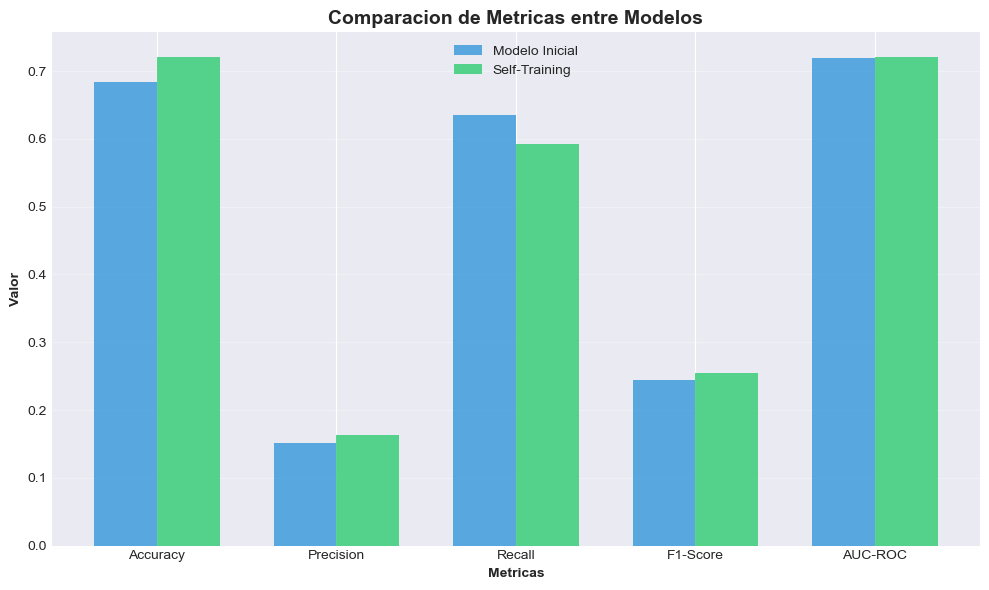

In [49]:
# 2. GRAFICO DE BARRAS - COMPARACION DE METRICAS
fig, ax = plt.subplots(figsize=(10, 6))

metricas = tabla_resultados['Metrica']
x = range(len(metricas))
ancho = 0.35

ax.bar([i - ancho/2 for i in x], tabla_resultados['Modelo Inicial'], 
       ancho, label='Modelo Inicial', color='#3498db', alpha=0.8)
ax.bar([i + ancho/2 for i in x], tabla_resultados['Self-Training'], 
       ancho, label='Self-Training', color='#2ecc71', alpha=0.8)

ax.set_xlabel('Metricas', fontweight='bold')
ax.set_ylabel('Valor', fontweight='bold')
ax.set_title('Comparacion de Metricas entre Modelos', fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metricas)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

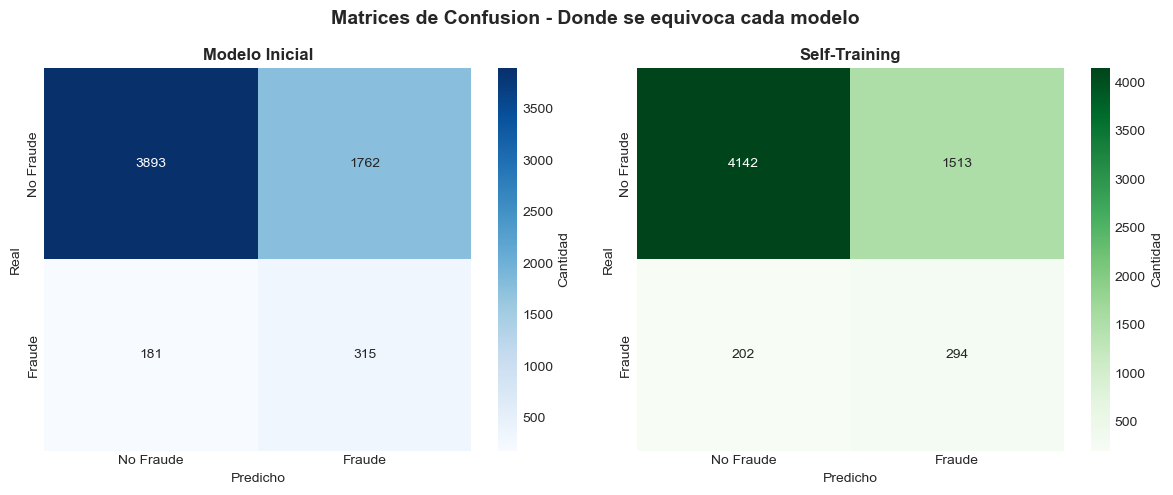


Lectura de la matriz:
- Diagonal (azul/verde oscuro): Predicciones correctas
- Fuera de diagonal: Errores del modelo


In [50]:
# 3. MATRIZ DE CONFUSION - VER DONDE ESTAN LOS ERRORES
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Modelo Inicial
cm_base = confusion_matrix(y_test, y_pred_base)
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            cbar_kws={'label': 'Cantidad'})
axes[0].set_title('Modelo Inicial', fontweight='bold')
axes[0].set_ylabel('Real')
axes[0].set_xlabel('Predicho')
axes[0].set_xticklabels(['No Fraude', 'Fraude'])
axes[0].set_yticklabels(['No Fraude', 'Fraude'])

# Self-Training
cm_st = confusion_matrix(y_test, y_pred_st)
sns.heatmap(cm_st, annot=True, fmt='d', cmap='Greens', ax=axes[1], 
            cbar_kws={'label': 'Cantidad'})
axes[1].set_title('Self-Training', fontweight='bold')
axes[1].set_ylabel('Real')
axes[1].set_xlabel('Predicho')
axes[1].set_xticklabels(['No Fraude', 'Fraude'])
axes[1].set_yticklabels(['No Fraude', 'Fraude'])

plt.suptitle('Matrices de Confusion - Donde se equivoca cada modelo', 
             fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

print("\nLectura de la matriz:")
print("- Diagonal (azul/verde oscuro): Predicciones correctas")
print("- Fuera de diagonal: Errores del modelo")

In [51]:
# 4. DETECCION DE FRAUDES - TABLA DETALLADA
tabla_fraudes = pd.DataFrame({
    'Categoria': [
        'Fraudes detectados correctamente',
        'Fraudes NO detectados (error)',
        'Falsas alarmas (error)',
        'No fraude correcto'
    ],
    'Modelo Inicial': [
        cm_base[1,1],  # Verdaderos positivos
        cm_base[1,0],  # Falsos negativos
        cm_base[0,1],  # Falsos positivos
        cm_base[0,0]   # Verdaderos negativos
    ],
    'Self-Training': [
        cm_st[1,1],
        cm_st[1,0],
        cm_st[0,1],
        cm_st[0,0]
    ]
})

print("ANALISIS DE DETECCION DE FRAUDES")
print("=" * 80)
print(tabla_fraudes.to_string(index=False))
print(f"\nTotal de fraudes reales en prueba: {cm_base[1,0] + cm_base[1,1]}")
print(f"Tasa de deteccion Modelo Inicial: {cm_base[1,1]/(cm_base[1,0] + cm_base[1,1])*100:.1f}%")
print(f"Tasa de deteccion Self-Training: {cm_st[1,1]/(cm_st[1,0] + cm_st[1,1])*100:.1f}%")

ANALISIS DE DETECCION DE FRAUDES
                       Categoria  Modelo Inicial  Self-Training
Fraudes detectados correctamente             315            294
   Fraudes NO detectados (error)             181            202
          Falsas alarmas (error)            1762           1513
              No fraude correcto            3893           4142

Total de fraudes reales en prueba: 496
Tasa de deteccion Modelo Inicial: 63.5%
Tasa de deteccion Self-Training: 59.3%


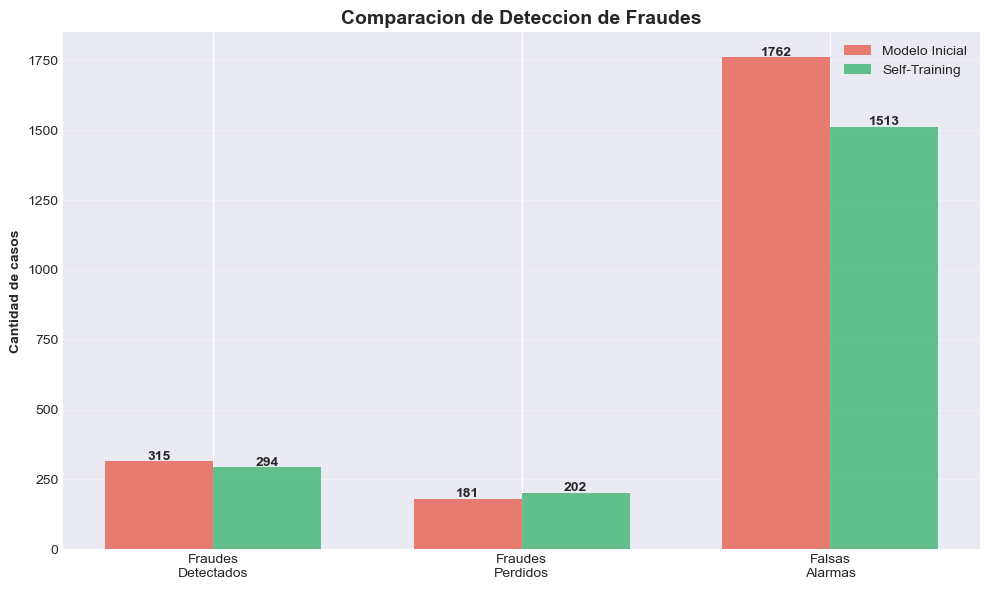

In [52]:
# 5. GRAFICO DE DETECCION DE FRAUDES
fig, ax = plt.subplots(figsize=(10, 6))

categorias = ['Fraudes\nDetectados', 'Fraudes\nPerdidos', 'Falsas\nAlarmas']
inicial = [cm_base[1,1], cm_base[1,0], cm_base[0,1]]
self_train = [cm_st[1,1], cm_st[1,0], cm_st[0,1]]

x = range(len(categorias))
ancho = 0.35

ax.bar([i - ancho/2 for i in x], inicial, ancho, 
       label='Modelo Inicial', color='#e74c3c', alpha=0.7)
ax.bar([i + ancho/2 for i in x], self_train, ancho, 
       label='Self-Training', color='#27ae60', alpha=0.7)

ax.set_ylabel('Cantidad de casos', fontweight='bold')
ax.set_title('Comparacion de Deteccion de Fraudes', fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(categorias)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Agregar valores en las barras
for i in x:
    ax.text(i - ancho/2, inicial[i] + 5, str(inicial[i]), 
            ha='center', fontweight='bold')
    ax.text(i + ancho/2, self_train[i] + 5, str(self_train[i]), 
            ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [60]:
# 6. DONDE ESTA EL FRAUDE - ANALISIS DE CARACTERISTICAS

# Separar fraudes y no fraudes
fraudes = datos_completos[datos_completos['objetivo'] == 1].copy()
no_fraudes = datos_completos[datos_completos['objetivo'] == 0].copy()

# Convertir dias a años (mas facil de entender)
fraudes['edad_anos'] = abs(fraudes['edad_dias']) / 365
no_fraudes['edad_anos'] = abs(no_fraudes['edad_dias']) / 365

# Variables a analizar
variables = ['ingreso_total', 'monto_credito', 'edad_anos', 'score_externo_2', 'score_externo_3']

# Crear tabla de comparacion
resultados = []
for var in variables:
    resultados.append({
        'Variable': var,
        'No Fraude': no_fraudes[var].mean(),
        'Fraude': fraudes[var].mean()
    })

tabla_fraudes = pd.DataFrame(resultados)

print("COMPARACION: FRAUDE vs NO FRAUDE")
print("=" * 70)
print(tabla_fraudes.to_string(index=False))

COMPARACION: FRAUDE vs NO FRAUDE
       Variable     No Fraude        Fraude
  ingreso_total 169077.722266 165611.760906
  monto_credito 602648.282002 557778.527674
      edad_anos     44.214182     40.780351
score_externo_2      0.523570      0.411260
score_externo_3      0.523767      0.423775
